In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_upstage import UpstageEmbeddings
from langchain_chroma import Chroma

embeddings = UpstageEmbeddings(model="solar-embedding-1-large")

vector_store = Chroma(collection_name="income_tax_collection",
                      embedding_function=embeddings,
                      persist_directory="./income_tax_collection")

retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [3]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list[Document]
    answer: str

graph_builder = StateGraph(AgentState)

In [4]:
def retrieve(state: AgentState) -> AgentState:
    query = state['query']
    docs = retriever.invoke(query)
    print(f"retrieve: {docs}")
    return {'context': docs}

In [5]:
from langchain import hub
from langchain_upstage import ChatUpstage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

llm = ChatUpstage()
generate_prompt = PromptTemplate.from_template(f"""
    [Identity]
    "당신은 소득세법 전문가입니다. 사용자의 소득세법에 관한 질문에 답변해주세요"
    "아래에 제공된 문서를 활용해서 답변해주시고"
    "답변을 알 수 없다면 모른다고 답변해주세요"
    "특히 소득세법 전문가이기 때문에 수학계산을 정확히 해주시길 바랍니다."
    "답변을 제공할 때는 소득세법 (XX조)에 따르면 이라고 시작하면서 답변해주세요."
        
    [Context]
    {{context}}
    
    Question: {{question}}
""" 
)

def generate(state: AgentState) -> AgentState:
    query = state['query']
    context = state['context']
    # 이곳에 StrOutputParser를 붙이지 않으면 rag_chain의 결과가 llm의 답변인 Message 객체가 됨
    # 하지만 우리 state에서 'answer'의 type은 str이므로 str로 바꿔줘야함
    # 여기서는 바꾸지 않아도 에러가 안나지만 에러가 날 때도 있다고 한다. 그건 나중에 공부해보자자
    rag_chain = generate_prompt | llm | StrOutputParser()
    response = rag_chain.invoke({'question': query, 'context': context})
    print(f"generate: {response}")
    return {'answer': response}

In [6]:
from typing import Literal
from langchain import hub

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    query = state['query']
    context = state['context']
    print(f"check_doc_relevance: {query}{context}")
    doc_relevance_chain = doc_relevance_prompt | llm
    print(f"check_doc_relevance: good")
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    print(f"check_doc_relevance: {response}")
    if response['Score'] == 1:
        return 'relevant'
    else:
        return 'irrelevant'

c:\Users\hyunseo\Desktop\learn_langgraph\.venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [7]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

keword_dictionary = ['사람과 관련된 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
    사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요 
    사전: {keword_dictionary}                                           
    질문: {{query}}
    """
)

def rewrite(state: AgentState) -> AgentState:
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({'query': query})
    print(f"rewrite: {response}")
    return {'query': response}

In [8]:
hallucination_prompt = PromptTemplate.from_template("""
    You are a teacher tasked with evaluating whether a student's answer is based on documents or not,
    Given documents, which are excerpts from income tax law, and a student's answer;
    If the student's answer is based on documents, respond with "not hallucinated",
    If the student's answer is not based on documents, respond with "hallucinated".

    documents: {documents}
    student_answer: {student_answer}
    """)

hallucination_llm = ChatUpstage(temperature=0)

def check_hallucination(state: AgentState) -> Literal['hallucinated', 'not hallucinated']:
    answer = state['answer']
    context = state['context']
    context = [doc.page_content for doc in context]
    hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
    response = hallucination_chain.invoke({'student_answer': answer, 'documents': context}).strip().lower().rstrip('.')
    print(f"check_hallucination: {response}")

    return response

In [9]:
from langchain import hub

# LangChain 허브에서 유용성 프롬프트를 가져옵니다
helpfulness_prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def check_helpfulness_grader(state: AgentState) -> Literal['helpful', 'unhelpful']:
    query = state['query']
    answer = state['answer']

    helpfulness_chain = helpfulness_prompt | llm
    
    response = helpfulness_chain.invoke({'question': query, 'student_answer': answer})
    print(f"check_helpfulness_grader: {response}")

    if response['Score'] == 1:
        return 'helpful'
    
    return 'unhelpful'

def check_helpfulness(state: AgentState) -> AgentState:
    return state

c:\Users\hyunseo\Desktop\learn_langgraph\.venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [10]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('check_helpfulness', check_helpfulness)

In [11]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance, 
    {
        'relevant': 'generate',
        'irrelevant': END
    }
)
graph_builder.add_conditional_edges(
    'generate',
    check_hallucination,
    {
        'not hallucinated': 'check_helpfulness',
        'hallucinated': 'generate'
    }
)

graph_builder.add_conditional_edges(
    'check_helpfulness',
    check_helpfulness_grader,
    {
        'helpful': END,
        'unhelpful': 'rewrite'
    }
)
graph_builder.add_edge('rewrite', 'retrieve')

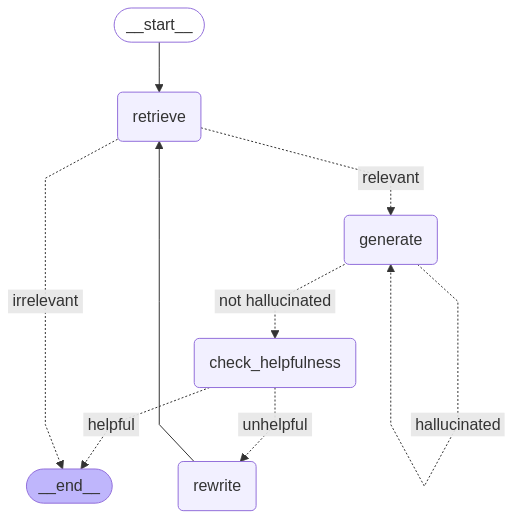

In [ ]:
# from IPython.display import Image, display

# graph = graph_builder.compile()

# display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# query = "종합소득과세표준이 5000만원인 거주자의 근로소득세는?"
# initial_state = {'query': query}
# graph.invoke(initial_state)

retrieve: [Document(id='f4e9684c-d1e8-4427-9727-4ab8dbb597f8', metadata={'source': './documents/income_tax.txt'}, page_content='| 종합소득 과세표준          | 세율                                         |\n|-------------------|--------------------------------------------|\n| 1,400만원 이하     | 과세표준의 6퍼센트                             |\n| 1,400만원 초과     5,000만원 이하     | 84만원 + (1,400만원을 초과하는 금액의 15퍼센트)  |\n| 5,000만원 초과   8,800만원 이하     | 624만원 + (5,000만원을 초과하는 금액의 24퍼센트) |\n| 8,800만원 초과 1억5천만원 이하    | 3,706만원 + (8,800만원을 초과하는 금액의 35퍼센트)|\n| 1억5천만원 초과 3억원 이하         | 3,706만원 + (1억5천만원을 초과하는 금액의 38퍼센트)|\n| 3억원 초과    5억원 이하         | 9,406만원 + (3억원을 초과하는 금액의 38퍼센트)   |\n| 5억원 초과      10억원 이하        | 1억 7,406만원 + (5억원을 초과하는 금액의 42퍼센트)|\n| 10억원 초과        | 3억 8,406만원 + (10억원을 초과하는 금액의 45퍼센트)|'), Document(id='05aa221c-2aa8-46bf-979c-70bc52d7a521', metadata={'source': './documents/income_tax.txt'}, page_content='130만원 이하   \n산출세액의 10분의 55 \n130만원 초과   \n71천원과 (130만원을 초과하는 금액의 10분의 30)  \n\n② 제1항에 대하여 공제

{'query': '종합소득과세표준이 5000만원인 거주자의 근로소득세는?',
 'context': [Document(id='f4e9684c-d1e8-4427-9727-4ab8dbb597f8', metadata={'source': './documents/income_tax.txt'}, page_content='| 종합소득 과세표준          | 세율                                         |\n|-------------------|--------------------------------------------|\n| 1,400만원 이하     | 과세표준의 6퍼센트                             |\n| 1,400만원 초과     5,000만원 이하     | 84만원 + (1,400만원을 초과하는 금액의 15퍼센트)  |\n| 5,000만원 초과   8,800만원 이하     | 624만원 + (5,000만원을 초과하는 금액의 24퍼센트) |\n| 8,800만원 초과 1억5천만원 이하    | 3,706만원 + (8,800만원을 초과하는 금액의 35퍼센트)|\n| 1억5천만원 초과 3억원 이하         | 3,706만원 + (1억5천만원을 초과하는 금액의 38퍼센트)|\n| 3억원 초과    5억원 이하         | 9,406만원 + (3억원을 초과하는 금액의 38퍼센트)   |\n| 5억원 초과      10억원 이하        | 1억 7,406만원 + (5억원을 초과하는 금액의 42퍼센트)|\n| 10억원 초과        | 3억 8,406만원 + (10억원을 초과하는 금액의 45퍼센트)|'),
  Document(id='05aa221c-2aa8-46bf-979c-70bc52d7a521', metadata={'source': './documents/income_tax.txt'}, page_content='130만원 이하   \n산출세액의 10분의 55 \n130만원 초과   \n71